# Neuropathology Visium Analysis
## Analysis of Cerebellar Layer Measurements Sorted by Gestational Age

This notebook analyzes measurements from different cerebellar layers (ML, IGL, EGL, WM) 
and creates heatmaps sorted by gestational age (GA).

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load and Initial Data Exploration

In [2]:
# Define file path - update this to your actual file location
csv_file_path = '/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium/measurements.csv'

# Load the data
print("Loading data from CSV file...")
df = pd.read_csv(csv_file_path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading data from CSV file...

Dataset shape: (75, 11)
Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Area µm^2', 'Perimeter µm']

First few rows:


,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Perimeter µm
0,1055A.tif - BF.ome.tif,3406140d-289a-4183-9c60-4b2bb3c46a4c,Annotation,4.0,WM,Root object (Image),Geometry,5575.6,5120.3,1009275.1,19417.1
1,1055A.tif - BF.ome.tif,7a6de77b-e1b3-49e9-aefd-00501e43ab69,Annotation,1.0,EGL,Root object (Image),Geometry,5002.9,5067.5,752911.5,63362.4
2,1055A.tif - BF.ome.tif,db96d5d0-a937-44fd-ad6c-12612a1cde6d,Annotation,3.0,ML,Root object (Image),Geometry,4726.3,4520.2,7956042.7,97074.1
3,1055A.tif - BF.ome.tif,ea3a6a5b-c59d-4b72-b6b8-4ac708b48167,Annotation,2.0,IGL,Root object (Image),Geometry,5044.4,4038.4,10152471.3,75625.2
4,1055A.tif - BF.ome.tif,d45c7934-8bf0-427a-b1b3-e5c21ba4b26f,Annotation,3.0,ML_IGL_150uM,Root object (Image),Geometry,5077.3,4261.5,4460116.7,62817.0


## 3. Data Preprocessing
### 3.1 Extract Sample ID and Image Letter from Image Column

In [3]:
# Extract sample information from the Image column
print("Extracting sample ID and image letter from Image column...")

# Step 1: Keep only the part before the first period
# Example: '1055A.tif-BF.ome.tif' -> '1055A'
df['temp'] = df['Image'].str.split('.', n=1).str[0]

# Step 2: Split into numeric (ID) and letter (Image) parts
# Example: '1055A' -> ID='1055', Image='A'
df['ID'] = df['temp'].str.extract('(\d+)', expand=False)  # Extract numbers
df['Image_Letter'] = df['temp'].str.extract('([A-Za-z]+)', expand=False)  # Extract letters

# Create Sample column by combining ID and Image_Letter
df['Sample'] = df['ID'] + df['Image_Letter']

# Drop the temporary column
df = df.drop('temp', axis=1)

# Display the results
print("\nSample ID and Image extraction complete:")
print(df[['Image', 'ID', 'Image_Letter', 'Sample']].head())

Extracting sample ID and image letter from Image column...

Sample ID and Image extraction complete:
                    Image    ID Image_Letter Sample
0  1055A.tif - BF.ome.tif  1055            A  1055A
1  1055A.tif - BF.ome.tif  1055            A  1055A
2  1055A.tif - BF.ome.tif  1055            A  1055A
3  1055A.tif - BF.ome.tif  1055            A  1055A
4  1055A.tif - BF.ome.tif  1055            A  1055A


### 3.2 Add Gestational Age (GA) Information

In [4]:
# Define GA mapping based on provided information
ga_mapping = {
    '1055': 38,
    '1061': 40,
    '1210': 39,
    '4276': 26,
    '4389': 34,
    '4544': 30,
    '934': 27
}

# Exclude ID 1208 as specified
print(f"\nNumber of rows before excluding ID 1208: {len(df)}")
df = df[df['ID'] != '1208']
print(f"Number of rows after excluding ID 1208: {len(df)}")

# Add GA_weeks column
df['GA_weeks'] = df['ID'].map(ga_mapping)

# Verify the mapping
print("\nGA mapping verification:")
ga_summary = df[['ID', 'GA_weeks']].drop_duplicates().sort_values('GA_weeks')
print(ga_summary)

# Check for any missing GA values
missing_ga = df[df['GA_weeks'].isnull()]['ID'].unique()
if len(missing_ga) > 0:
    print(f"\nWarning: The following IDs have no GA mapping: {missing_ga}")


Number of rows before excluding ID 1208: 75
Number of rows after excluding ID 1208: 65

GA mapping verification:
      ID  GA_weeks
35  4276        26
65   934        27
55  4544        30
45  4389        34
0   1055        38
25  1210        39
10  1061        40


### 3.3 Clean Column Names and Check Classifications

In [5]:
# Rename columns to remove units for easier handling
df = df.rename(columns={
    'Area µm^2': 'Area',
    'Perimeter µm': 'Perimeter',
    'Centroid X µm': 'Centroid_X',
    'Centroid Y µm': 'Centroid_Y'
})

print("Column names cleaned.")

# Check unique classifications
print("\nUnique classifications in the dataset:")
print(df['Classification'].unique())

# Note: We keep ML_IGL_150uM in the dataset for normalization purposes
# It will be used for perimeter calculation but excluded from visualizations
if 'ML_IGL_150uM' in df['Classification'].unique():
    print("\nML_IGL_150uM found - keeping it for perimeter normalization")
    ml_igl_count = len(df[df['Classification'] == 'ML_IGL_150uM'])
    print(f"Number of ML_IGL_150uM measurements: {ml_igl_count}")

Column names cleaned.

Unique classifications in the dataset:
['WM' 'EGL' 'ML' 'IGL' 'ML_IGL_150uM']

ML_IGL_150uM found - keeping it for perimeter normalization
Number of ML_IGL_150uM measurements: 13


## 4. Calculate Normalized Areas

### Normalization: Total Area / (Layer Perimeter / 2)
As per the methodology: area(μm²) / (perimeter(μm)/2) = normalized area

In [6]:
def calculate_normalized_areas(df):
    """
    Calculate normalized areas for all layers using ML_IGL_150uM perimeter as reference.
    
    For each sample:
    - Use ML_IGL_150uM perimeter / 2 as the normalization factor
    - Calculate area / (ML_IGL_150uM perimeter / 2) for each layer
    - ML_IGL_150uM is used ONLY for perimeter, not included in area calculations
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The data containing area and perimeter measurements
    
    Returns:
    --------
    dict
        Dictionary with layer names as keys and normalized areas as values
    """
    # First, get ML_IGL_150uM perimeter for each sample (this will be our reference)
    ml_igl_data = df[df['Classification'] == 'ML_IGL_150uM']
    
    if len(ml_igl_data) == 0:
        print("Error: No ML_IGL_150uM data found. Cannot normalize without ML_IGL_150uM perimeter.")
        return {}
    
    # Get ML_IGL_150uM perimeter for each sample
    ml_igl_perimeters = ml_igl_data.groupby('Sample')['Perimeter'].first()
    
    # Calculate length (perimeter / 2)
    ml_igl_lengths = ml_igl_perimeters / 2
    
    print(f"Found ML_IGL_150uM perimeter data for {len(ml_igl_lengths)} samples")
    
    # Initialize results dictionary
    normalized_data = {}
    
    # For each layer (excluding ML_IGL_150uM), calculate its area normalized by ML_IGL_150uM length
    layers = ['ML', 'IGL', 'EGL', 'WM']  # Note: ML_IGL_150uM is NOT included here
    
    for layer in layers:
        # Get area data for this layer
        layer_data = df[df['Classification'] == layer]
        
        if len(layer_data) == 0:
            print(f"Warning: No data found for {layer} classification")
            normalized_data[layer] = pd.Series()
            continue
        
        # Get area for each sample (using first occurrence if multiple)
        layer_areas = layer_data.groupby('Sample')['Area'].first()
        
        # Find samples that have both ML_IGL_150uM perimeter and layer area
        common_samples = ml_igl_lengths.index.intersection(layer_areas.index)
        
        if len(common_samples) == 0:
            print(f"Warning: No common samples between ML_IGL_150uM and {layer}")
            normalized_data[layer] = pd.Series()
            continue
        
        # Calculate normalized area: Layer Area / ML_IGL_150uM Length
        normalized_areas = layer_areas[common_samples] / ml_igl_lengths[common_samples]
        
        normalized_data[layer] = normalized_areas
        
        print(f"{layer}: Found {len(common_samples)} samples with both area and ML_IGL_150uM perimeter")
    
    return normalized_data

# Calculate normalized areas for all layers
print("Calculating normalized areas using ML_IGL_150uM perimeter as reference...")
normalized_data = calculate_normalized_areas(df)

# Display statistics for each layer
layers = ['ML', 'IGL', 'EGL', 'WM']
for layer in layers:
    if layer in normalized_data and len(normalized_data[layer]) > 0:
        print(f"\n{layer} - Number of samples: {len(normalized_data[layer])}")
        print(f"Mean normalized area: {normalized_data[layer].mean():.2f}")
        print(f"Std deviation: {normalized_data[layer].std():.2f}")
        print(f"Range: {normalized_data[layer].min():.2f} - {normalized_data[layer].max():.2f}")

Calculating normalized areas using ML_IGL_150uM perimeter as reference...
Found ML_IGL_150uM perimeter data for 13 samples
ML: Found 13 samples with both area and ML_IGL_150uM perimeter
IGL: Found 13 samples with both area and ML_IGL_150uM perimeter
EGL: Found 13 samples with both area and ML_IGL_150uM perimeter
WM: Found 13 samples with both area and ML_IGL_150uM perimeter

ML - Number of samples: 13
Mean normalized area: 171.65
Std deviation: 40.76
Range: 122.72 - 253.31

IGL - Number of samples: 13
Mean normalized area: 270.49
Std deviation: 110.50
Range: 129.09 - 451.70

EGL - Number of samples: 13
Mean normalized area: 28.33
Std deviation: 13.46
Range: 13.89 - 57.41

WM - Number of samples: 13
Mean normalized area: 69.61
Std deviation: 61.14
Range: 17.61 - 198.21


## 5. Create Combined DataFrame with GA Information

In [7]:
# Create a combined dataframe for all normalized values
combined_df = pd.DataFrame()

# Add normalized values for each layer
for layer in layers:
    if len(normalized_data[layer]) > 0:
        # Convert series to dataframe and reset index to avoid ambiguity
        temp_df = normalized_data[layer].to_frame(name=f'{layer}_Normalized').reset_index()
        temp_df.columns = ['Sample', f'{layer}_Normalized']
        
        # Add GA information
        sample_to_ga = df[['Sample', 'GA_weeks']].drop_duplicates().set_index('Sample')['GA_weeks']
        temp_df['GA_weeks'] = temp_df['Sample'].map(sample_to_ga)
        
        if combined_df.empty:
            combined_df = temp_df
        else:
            # Merge only the normalized column for subsequent layers
            combined_df = combined_df.merge(temp_df[['Sample', f'{layer}_Normalized']], 
                                            on='Sample', how='outer')

# Sort by GA weeks
combined_df = combined_df.sort_values('GA_weeks')

print("Combined dataframe with all normalized values:")
print(combined_df)

Combined dataframe with all normalized values:
   Sample  ML_Normalized  GA_weeks  IGL_Normalized  EGL_Normalized  \
5   4276A     122.717920        26      323.545882       26.144181   
6   4276B     136.616863        26      298.291653       27.867158   
11   934A     145.183876        27      451.704333       48.125342   
12   934B     169.537629        27      431.864372       57.414703   
9   4544A     142.186979        30      129.086973       13.889901   
10  4544B     140.987026        30      135.011344       15.474365   
7   4389A     162.562353        34      181.923647       23.351900   
8   4389B     165.667339        34      185.517263       25.111152   
0   1055A     253.308585        38      323.239610       23.971584   
1   1055B     253.124549        38      365.587278       44.583813   
3   1210A     169.218871        39      196.713691       17.577941   
4   1210B     186.305830        39      168.677921       17.171868   
2   1061A     184.072564        40      325

## 6. Create Individual Heatmaps for Each Layer (Sorted by GA)

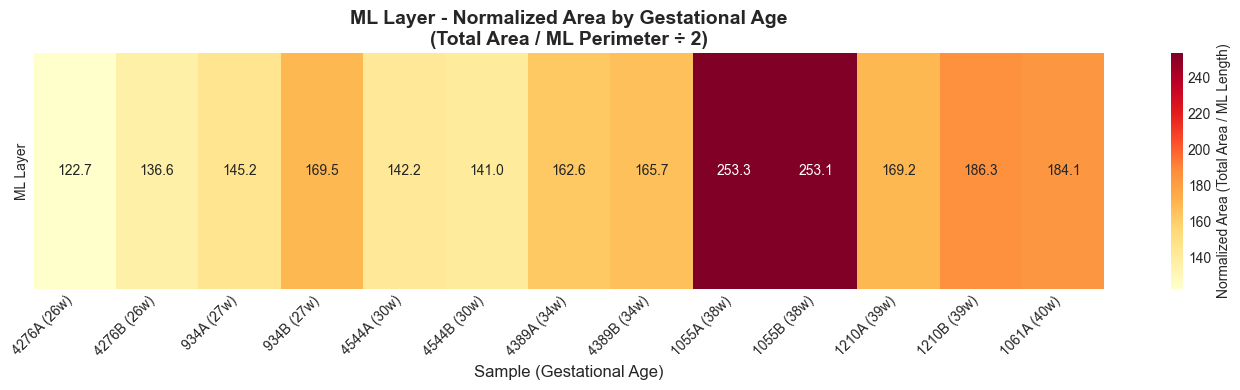


ML Layer Statistics:
Samples: 13
Mean: 171.65
Std: 40.76
Range: 122.72 - 253.31


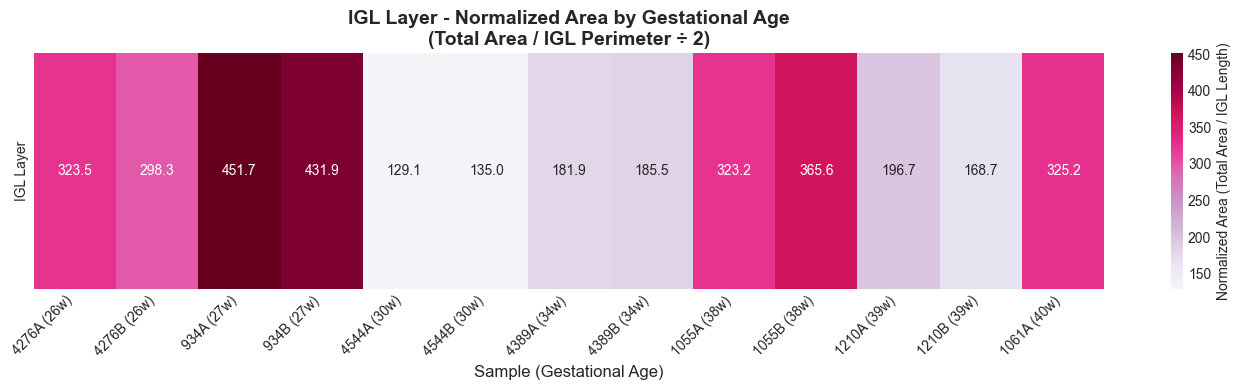


IGL Layer Statistics:
Samples: 13
Mean: 270.49
Std: 110.50
Range: 129.09 - 451.70


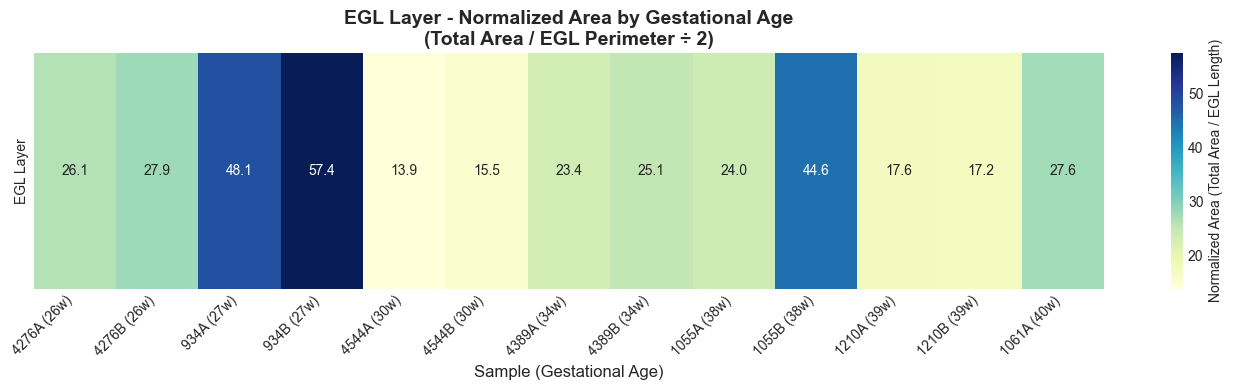


EGL Layer Statistics:
Samples: 13
Mean: 28.33
Std: 13.46
Range: 13.89 - 57.41


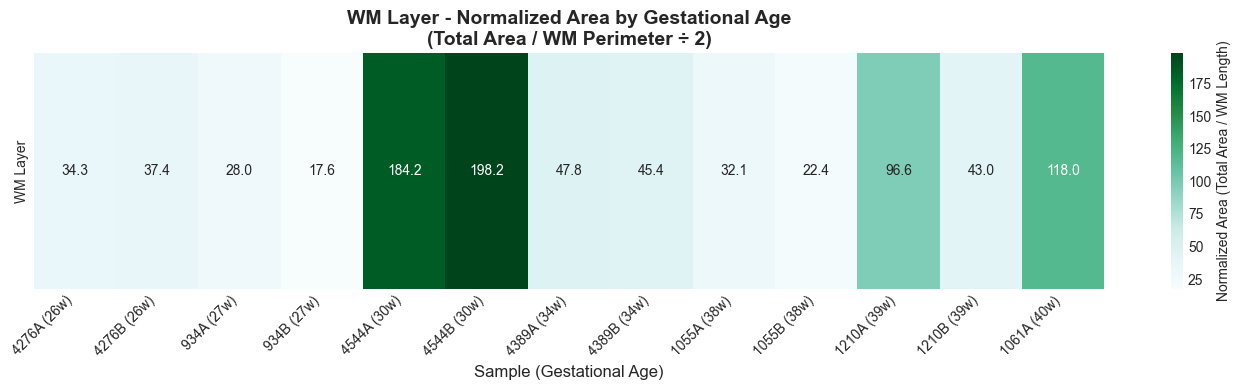


WM Layer Statistics:
Samples: 13
Mean: 69.61
Std: 61.14
Range: 17.61 - 198.21


In [8]:
# Define color schemes for each layer
color_schemes = {
    'ML': 'YlOrRd',     # Yellow to Orange to Red
    'IGL': 'PuRd',      # Purple to Red
    'EGL': 'YlGnBu',    # Yellow to Green to Blue
    'WM': 'BuGn'        # Blue to Green
}

# Create individual heatmaps for each layer
for layer in layers:
    if f'{layer}_Normalized' not in combined_df.columns:
        print(f"\nSkipping {layer} - no data available")
        continue
    
    # Prepare data for heatmap
    heatmap_data = combined_df[['Sample', 'GA_weeks', f'{layer}_Normalized']].dropna()
    
    if len(heatmap_data) == 0:
        print(f"\nNo data available for {layer} layer")
        continue
    
    # Create sample labels with GA information
    heatmap_data['Sample_GA'] = heatmap_data['Sample'] + ' (' + heatmap_data['GA_weeks'].astype(str) + 'w)'
    
    # Pivot for heatmap format
    heatmap_matrix = heatmap_data.set_index('Sample_GA')[[f'{layer}_Normalized']].T
    
    # Create figure
    plt.figure(figsize=(14, 4))
    
    # Create heatmap
    sns.heatmap(heatmap_matrix,
                cmap=color_schemes[layer],
                annot=True,
                fmt='.1f',
                cbar_kws={'label': f'Normalized Area (Total Area / {layer} Length)'},
                xticklabels=True,
                yticklabels=[f'{layer} Layer'])
    
    # Customize plot
    plt.title(f'{layer} Layer - Normalized Area by Gestational Age\n(Total Area / {layer} Perimeter ÷ 2)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Sample (Gestational Age)', fontsize=12)
    plt.ylabel('')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print statistics
    print(f"\n{layer} Layer Statistics:")
    print(f"Samples: {len(heatmap_data)}")
    print(f"Mean: {heatmap_data[f'{layer}_Normalized'].mean():.2f}")
    print(f"Std: {heatmap_data[f'{layer}_Normalized'].std():.2f}")
    print(f"Range: {heatmap_data[f'{layer}_Normalized'].min():.2f} - {heatmap_data[f'{layer}_Normalized'].max():.2f}")


## 7. Create Combined Heatmap (All Layers)

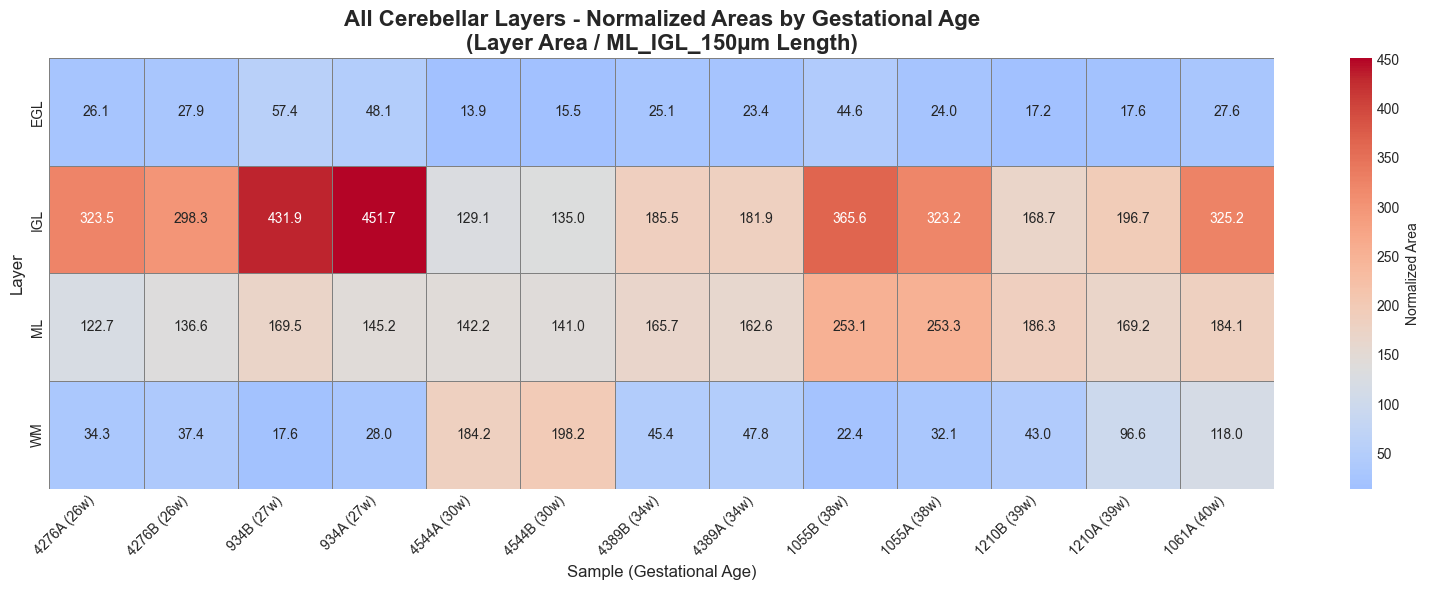

In [11]:
# Prepare data for combined heatmap
heatmap_combined = pd.DataFrame()

for layer in layers:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        layer_data = combined_df[['Sample', 'GA_weeks', col_name]].dropna()
        layer_data['Layer'] = layer
        layer_data['Value'] = layer_data[col_name]
        layer_data['Sample_GA'] = layer_data['Sample'] + ' (' + layer_data['GA_weeks'].astype(str) + 'w)'
        heatmap_combined = pd.concat([heatmap_combined, layer_data[['Sample_GA', 'Layer', 'Value', 'GA_weeks']]])

# Pivot for heatmap
if not heatmap_combined.empty:
    # Sort by GA weeks
    sample_order = heatmap_combined.sort_values('GA_weeks')['Sample_GA'].unique()
    
    heatmap_pivot = heatmap_combined.pivot(index='Layer', columns='Sample_GA', values='Value')
    heatmap_pivot = heatmap_pivot[sample_order]  # Reorder columns by GA
    
    # Create figure
    plt.figure(figsize=(16, 6))
    
    # Create heatmap with a different colormap
    # Options: 'coolwarm', 'RdYlBu_r', 'plasma', 'inferno', 'magma', 'cividis', 'twilight', 'rainbow'
    sns.heatmap(heatmap_pivot,
                cmap='coolwarm',  # Blue to Red through white
                annot=True,
                fmt='.1f',
                cbar_kws={'label': 'Normalized Area'},
                linewidths=0.5,
                linecolor='gray',
                center=heatmap_pivot.mean().mean())  # Center the colormap at the mean value
    
    # Customize plot
    plt.title('All Cerebellar Layers - Normalized Areas by Gestational Age\n(Layer Area / ML_IGL_150µm Length)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Sample (Gestational Age)', fontsize=12)
    plt.ylabel('Layer', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

## 8. Statistical Analysis and Trends

Analyzing trends across gestational ages...

Correlation between GA and normalized areas:
ML: 0.709
WM: 0.044
IGL: -0.261
EGL: -0.314


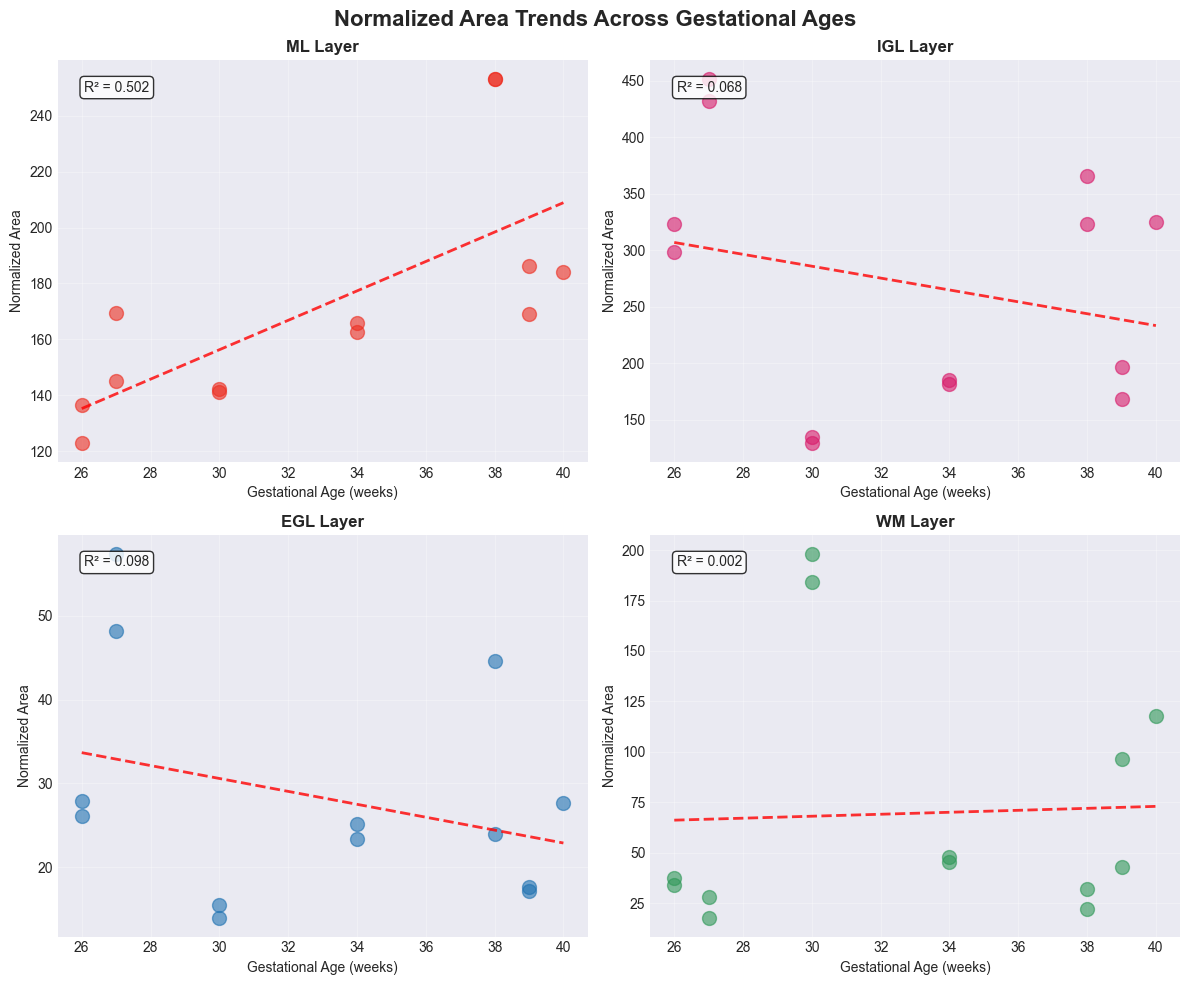

In [10]:
# Analyze trends across gestational ages
print("Analyzing trends across gestational ages...\n")

# Create correlation matrix between GA and normalized areas
correlation_data = combined_df[['GA_weeks'] + [f'{layer}_Normalized' for layer in layers if f'{layer}_Normalized' in combined_df.columns]].corr()

# Display correlations with GA
ga_correlations = correlation_data['GA_weeks'].drop('GA_weeks').sort_values(ascending=False)
print("Correlation between GA and normalized areas:")
for layer_col, corr in ga_correlations.items():
    layer_name = layer_col.replace('_Normalized', '')
    print(f"{layer_name}: {corr:.3f}")

# Create scatter plots with trend lines
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, layer in enumerate(layers):
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        ax = axes[i]
        
        # Prepare data
        plot_data = combined_df[['GA_weeks', col_name]].dropna()
        
        # Create scatter plot
        ax.scatter(plot_data['GA_weeks'], plot_data[col_name], 
                  s=100, alpha=0.6, color=plt.cm.get_cmap(color_schemes[layer])(0.7))
        
        # Add trend line
        if len(plot_data) > 2:
            z = np.polyfit(plot_data['GA_weeks'], plot_data[col_name], 1)
            p = np.poly1d(z)
            ax.plot(plot_data['GA_weeks'], p(plot_data['GA_weeks']), 
                   "r--", alpha=0.8, linewidth=2)
            
            # Add R² value
            from sklearn.metrics import r2_score
            r2 = r2_score(plot_data[col_name], p(plot_data['GA_weeks']))
            ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Customize subplot
        ax.set_xlabel('Gestational Age (weeks)', fontsize=10)
        ax.set_ylabel('Normalized Area', fontsize=10)
        ax.set_title(f'{layer} Layer', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Add main title
fig.suptitle('Normalized Area Trends Across Gestational Ages', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()